<a href="https://colab.research.google.com/github/jyj1206/StandaloneDeepLearning/blob/main/Chapter7_Implementing_ResNet_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir results

In [2]:
# 라이브 불러오기
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Cifar-100 데이터 불러오기
transform_train = transforms.Compose(
    [
    transforms.RandomCrop(32, padding=4),  # 랜덤 크기 조정 + 패딩
    transforms.RandomHorizontalFlip(),  # 랜덤 수평 뒤집기
    transforms.RandomRotation(15),  # 랜덤 회전 (±15도)
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
partition = {'train': trainset, 'val':valset, 'test':testset}

100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# conv 3x3 과 conv 1x1 function 생성
def conv3x3(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [5]:
# 2개의 conv 3x3 layer와 skip connection으로 구성된 BasicBlock module
# ResNet-18, RestNet-34에 사용
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super(BasicBlock, self).__init__()
    self.conv1 = conv3x3(inplanes, planes, stride)
    self.bn1 = nn.BatchNorm2d(planes)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = nn.BatchNorm2d(planes)
    self.downsample = downsample # 나중에 ResNet에서 처리함 (중요)
    self.stride = stride

  def forward(self, x):
    identity = x # 입력값을 나중에 더 해주기 위해 미리 저장

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None: # downsample : skip connection을 할 때 입력한 depth와 출력의 depth가 다른 경우 depth를 맞춰주기 함
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

In [6]:
# computational efficency를 증가시키기 위해 3x3 conv 앞뒤로 1x1 conv를 추가한 Bottleneck module
# ResNet-50, ResNet-101, ResNet-152 등에 사용함
class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super(Bottleneck, self).__init__()
    self.conv1 = conv1x1(inplanes, planes)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = conv3x3(planes, planes, stride)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = conv1x1(planes, planes * self.expansion)
    self.bn3 = nn.BatchNorm2d(planes * self.expansion)
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
      identity = x

      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)

      out = self.conv2(out)
      out = self.bn2(out)

      out = self.conv3(out)
      out = self.bn3(out)

      if self.downsample is not None:
          identity = self.downsample(x)

      out += identity
      out = self.relu(out)

      return out

In [7]:
# ResNet 생성
class ResNet(nn.Module):

    def __init__(self, block, layers, kernel_size=7, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size = kernel_size, stride=2, padding=(kernel_size//2),
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [8]:
# 학습 함수 생성
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()

        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [9]:
# 검증 함수 생성
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [10]:
# 테스트 함수 생성
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 실험 함수 생성
def experiment(partition, args):

    net = ResNet(block=args.block, layers=args.layers, kernel_size = args.kernel_size , num_classes=args.num_classes)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Current learning rate: {}, Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, scheduler.get_last_lr()[0], te-ts))

        scheduler.step(val_loss)  # val_loss가 개선되지 않으면 학습률을 감소시킴

    test_acc = test(net, partition, args)

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [12]:
# 실험 결과 저장 및 불러오기 함수
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [13]:
# 시각화 함수
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])

    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')


def plot_loss_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []
    for value1 in list_v1:
      for value2 in list_v2:
          row = df.loc[df[var1]==value1]
          row = row.loc[df[var2]==value2]

          train_losses = list(row.train_losses)[0]
          val_losses = list(row.val_losses)[0]

          for epoch, train_loss in enumerate(train_losses):
              list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
          for epoch, val_loss in enumerate(val_losses):
              list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1] == value1]
            row = row.loc[df[var2] == value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            max_val_acc = max(val_accs)  # 최대 val accuracy 계산

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type': 'train', 'Acc': train_acc, 'max_val_acc': max_val_acc, 'epoch': epoch, var1: value1, var2: value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type': 'val', 'Acc': val_acc, 'max_val_acc': max_val_acc, 'epoch': epoch, var1: value1, var2: value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Max Val Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric, horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))

    g = g.map(show_acc, 'epoch', 'Acc', 'max_val_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')

    plt.subplots_adjust(top=0.89)

    plt.show()

In [15]:
# 모델 파라미터 정 및 실험
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ====== Model ====== #
args.block = BasicBlock
args.layers = [2, 2, 2, 2]
args.num_classes = 100
args.kernel_size = 7

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 30

args.train_batch_size = 1024
args.test_batch_size = 2048

# ====== Experiment Variable ====== #
name_var1 = 'model_name'
name_var2 = 'lr'
model_variants = {
    "ResNet-18": {"block": BasicBlock, "layers": [2, 2, 2, 2]},
    "ResNet-34": {"block": BasicBlock, "layers": [3, 4, 6, 3]},
    "ResNet-50": {"block": Bottleneck, "layers": [3, 4, 6, 3]},
}
list_var2 = [0.001, 0.0001, 0.00001]

args.exp_name = f"exp_{name_var1}_{name_var2}"  # 실험 이름 설정

# 실험 반복
for model_name, model_config in model_variants.items():
  for var2 in list_var2:
    var1 = model_name
    setattr(args, name_var1, var1)
    setattr(args, name_var2, var2)

    # 모델 구성 설정
    args.block = model_config["block"]
    args.layers = model_config["layers"]

    print(f"Running experiment for {model_name}...")
    print(f"Block Type: {args.block.__name__}, Layers: {args.layers}, Experiment Name: {args.exp_name}")

    # 실험 실행
    setting, result = experiment(partition, deepcopy(args))

    setting['block'] = args.block.__name__

    # 결과 저장
    save_exp_result(setting, result)

Running experiment for ResNet-18...
Block Type: BasicBlock, Layers: [2, 2, 2, 2], Experiment Name: exp_model_name_lr
Epoch 0, Acc(train/val): 3.85/4.27, Loss(train/val) 4.51/4.52. Current learning rate: 0.001, Took 15.11 sec
Epoch 1, Acc(train/val): 9.03/3.64, Loss(train/val) 3.91/4.82. Current learning rate: 0.001, Took 13.94 sec
Epoch 2, Acc(train/val): 13.34/5.18, Loss(train/val) 3.65/5.29. Current learning rate: 0.001, Took 14.14 sec
Epoch 3, Acc(train/val): 16.41/4.70, Loss(train/val) 3.47/5.71. Current learning rate: 0.001, Took 14.24 sec
Epoch 4, Acc(train/val): 19.39/9.46, Loss(train/val) 3.30/4.14. Current learning rate: 0.001, Took 14.12 sec
Epoch 5, Acc(train/val): 22.30/4.42, Loss(train/val) 3.14/8.84. Current learning rate: 0.001, Took 13.98 sec
Epoch 6, Acc(train/val): 24.68/9.70, Loss(train/val) 3.03/4.52. Current learning rate: 0.001, Took 14.40 sec
Epoch 7, Acc(train/val): 26.34/9.99, Loss(train/val) 2.95/4.53. Current learning rate: 0.001, Took 14.27 sec
Epoch 8, Acc(

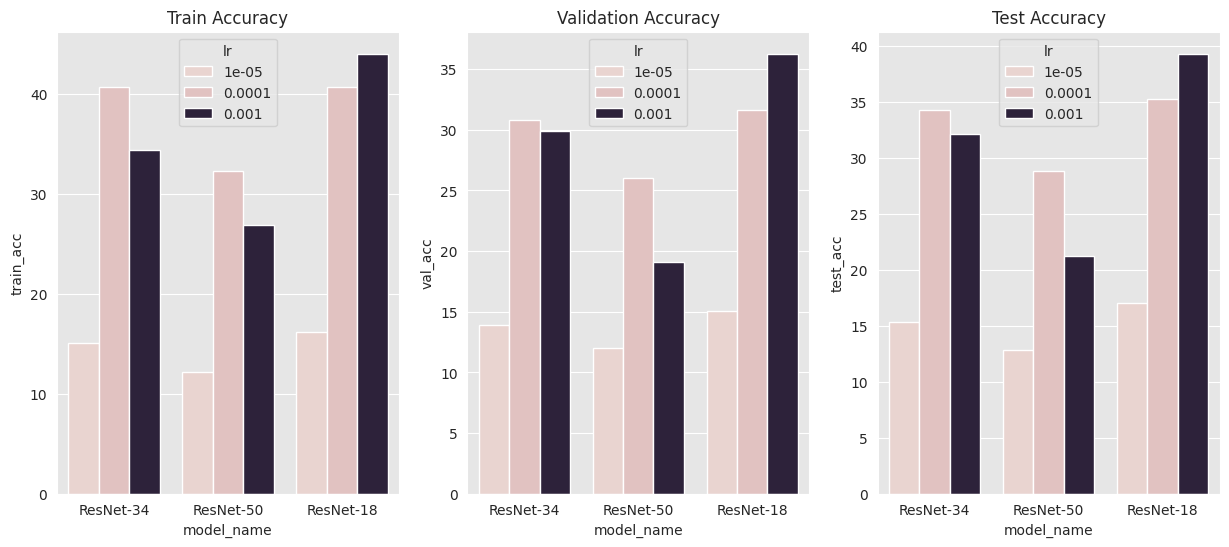

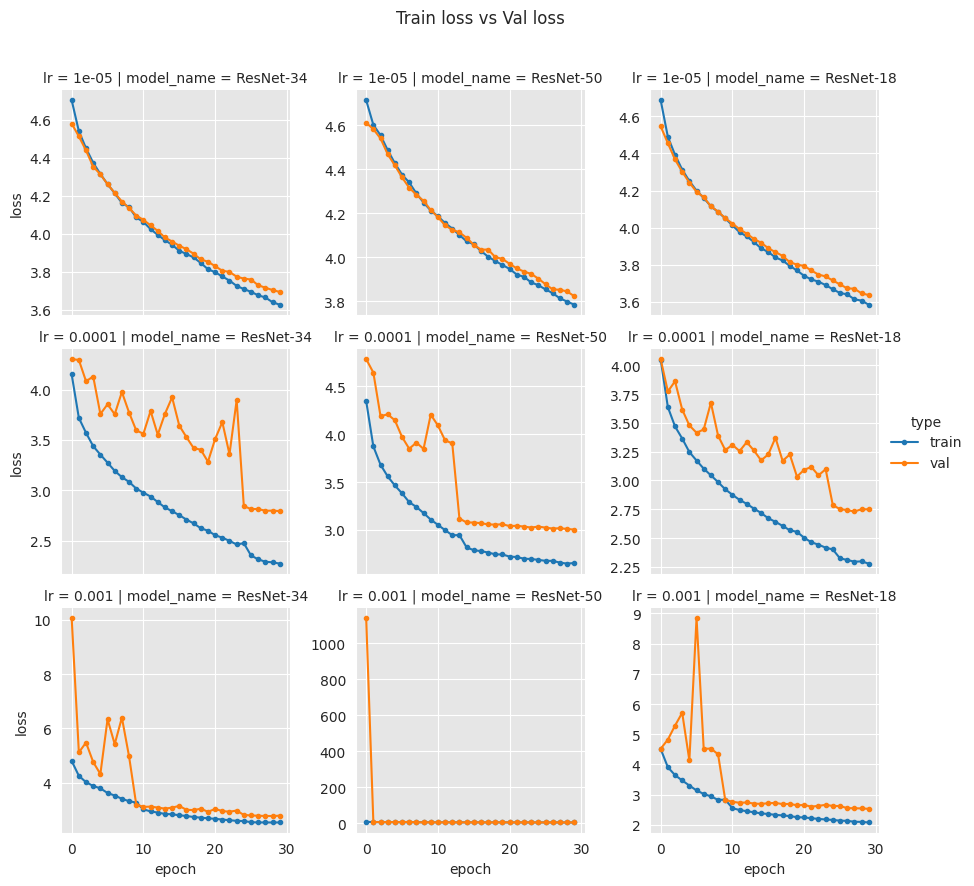

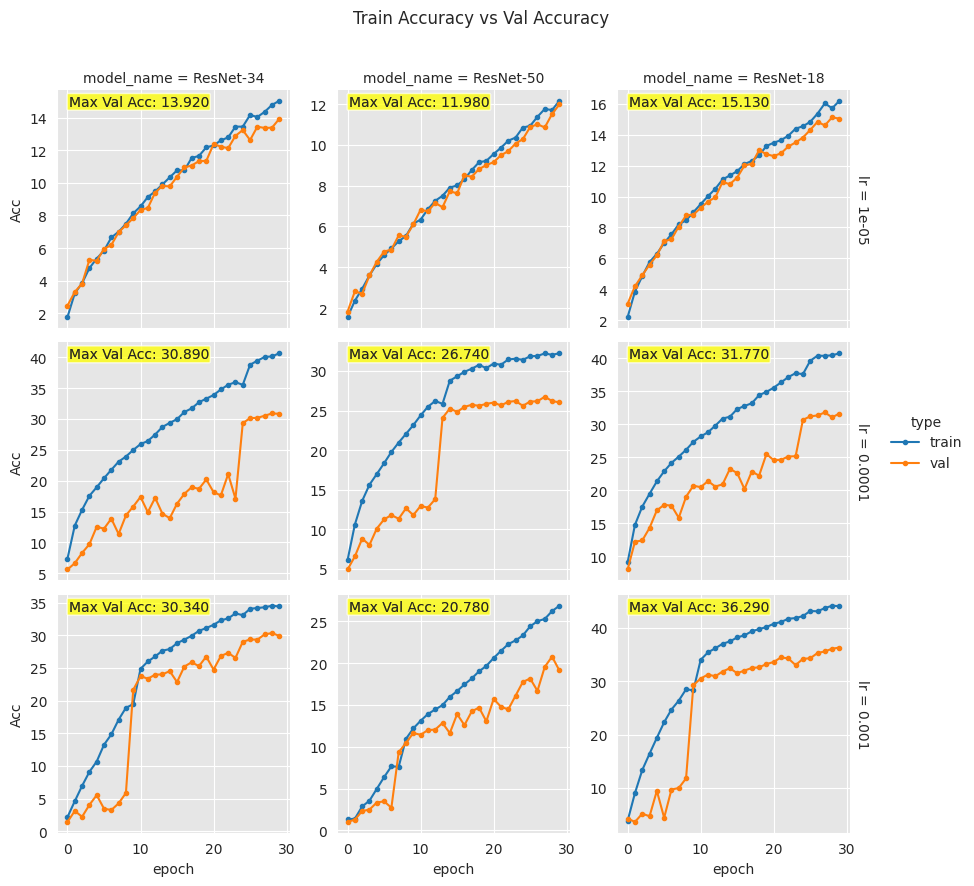

In [20]:
var1 = 'model_name'
var2 = 'lr'
df = load_exp_result('exp')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.